## 🌡️ Temperature vs S&P 500 Returns

**Goal:**  
Examine whether average daily temperature in New York City is correlated with daily returns of the S&P 500 index. We'll calculate the correlation, create a scatterplot, and fit a basic linear regression model.

**Why it matters:**  
Behavioral finance suggests that weather — especially temperature — may affect investor mood and risk tolerance.


In [13]:
from meteostat import Point, Daily
from datetime import datetime
import pandas as pd

# Define date range and location
start = datetime(2019, 1, 1)
end = datetime(2024, 12, 31)
nyc = Point(40.7128, -74.0060)

# Fetch daily weather data
weather = Daily(nyc, start, end).fetch().reset_index()

# Clean column names
weather = weather[['time', 'tavg', 'prcp', 'wspd']]
weather.columns = ['Date', 'AvgTemp', 'Precip', 'WindSpeed']
weather['Date'] = pd.to_datetime(weather['Date'])

# Preview weather data
weather.head()


,Date,AvgTemp,Precip,WindSpeed
0,2019-01-01,10.6,2.0,13.1
1,2019-01-02,4.0,0.0,8.9
2,2019-01-03,5.7,0.0,9.0
3,2019-01-04,4.8,0.0,12.8
4,2019-01-05,7.1,15.5,12.8


In [15]:
# Load the S&P 500 CSV (make sure it's in your notebook folder)
sp500 = pd.read_csv("sp500.csv")

# Convert date column
sp500['Date'] = pd.to_datetime(sp500['Date'])

# Calculate daily returns
sp500['Daily Return'] = sp500['Close/Last'].pct_change()

# Sort and preview
sp500 = sp500.sort_values('Date')
sp500.head()


,Date,Close/Last,Open,High,Low,Daily Return
1255,2020-05-07,2881.19,2878.26,2901.92,2876.48,-0.016592
1254,2020-05-08,2929.80,2908.83,2932.16,2902.88,-0.000177
1253,2020-05-11,2930.32,2915.46,2944.25,2903.44,0.020975
1252,2020-05-12,2870.12,2939.50,2945.82,2869.59,0.017773
1251,2020-05-13,2820.00,2865.86,2874.14,2793.15,-0.011394


In [17]:
import pandas as pd
from meteostat import Point, Daily
from datetime import datetime
import yfinance as yf

# Set time range
start = datetime(2019, 1, 1)
end = datetime(2024, 12, 31)

# Load NYC weather
nyc = Point(40.7128, -74.0060)
weather = Daily(nyc, start, end).fetch().reset_index()
weather = weather[['time', 'tavg', 'prcp', 'wspd']]
weather.columns = ['Date', 'AvgTemp', 'Precip', 'WindSpeed']
weather['Date'] = pd.to_datetime(weather['Date'])

# Load S&P 500 data from CSV
sp500 = pd.read_csv("sp500.csv")  # or use yfinance if no CSV
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['Daily Return'] = sp500['Close/Last'].pct_change()
sp500 = sp500.sort_values('Date')

# Merge
merged = pd.merge(sp500, weather, on='Date', how='inner').dropna()


Correlation between temperature and return: 0.0110


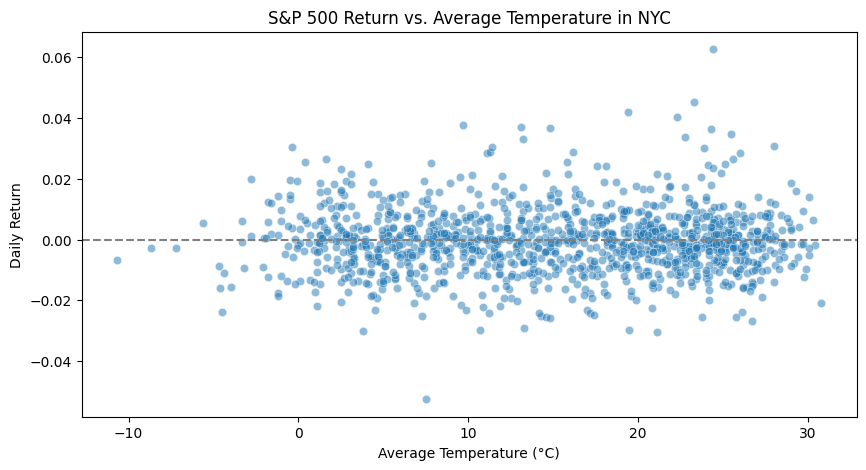

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Correlation coefficient
corr_temp_return, _ = pearsonr(merged['AvgTemp'], merged['Daily Return'])
print(f"Correlation between temperature and return: {corr_temp_return:.4f}")

# Scatterplot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged, x='AvgTemp', y='Daily Return', alpha=0.5)
plt.title('S&P 500 Return vs. Average Temperature in NYC')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Daily Return')
plt.axhline(0, color='gray', linestyle='--')
plt.show()


## 🌧️ Rainy vs Non-Rainy Day Returns

**Goal:**  
Determine whether the S&P 500 performs differently on rainy days compared to dry days in New York City. We'll define "rainy" as any day where precipitation is greater than 0 mm.

**Why it matters:**  
Rain may influence investor sentiment, potentially making markets more cautious or reactive. We'll compare average returns and visualize the distribution of returns for both rainy and non-rainy days.


Average Return on Dry Days: -0.0006044962135541237
Average Return on Rainy Days: -0.0005022001887321203


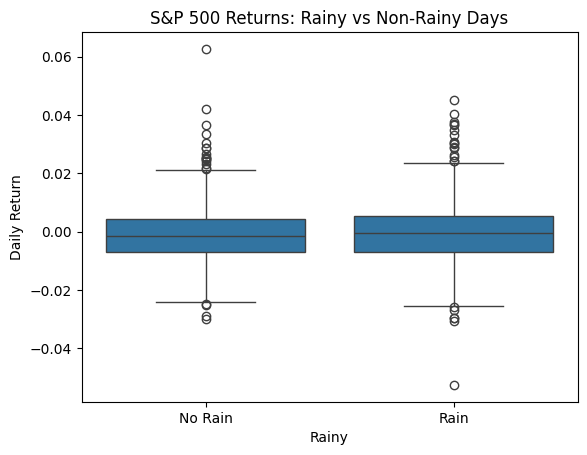

In [19]:
import numpy as np

# Create a binary column: 1 = Rainy, 0 = Not Rainy
merged['Rainy'] = (merged['Precip'] > 0).astype(int)

# Compare average return
avg_returns_by_rain = merged.groupby('Rainy')['Daily Return'].mean()
print("Average Return on Dry Days:", avg_returns_by_rain[0])
print("Average Return on Rainy Days:", avg_returns_by_rain[1])

# Boxplot
sns.boxplot(data=merged, x='Rainy', y='Daily Return')
plt.xticks([0, 1], ['No Rain', 'Rain'])
plt.title('S&P 500 Returns: Rainy vs Non-Rainy Days')
plt.ylabel('Daily Return')
plt.show()


## 🌬️ Wind Speed and Market Volatility

**Goal:**  
Investigate whether daily wind speed in NYC is associated with market volatility. We’ll use the absolute value of daily returns as a proxy for volatility.

**Why it matters:**  
Higher wind speeds may be linked with storms or mood shifts — potentially increasing uncertainty in markets. While subtle, this can reflect behavioral effects or risk sensitivity.

**Approach:**
- Measure volatility as `abs(Daily Return)`
- Correlate it with `WindSpeed`
- Visualize using a scatterplot


Correlation between Wind Speed and Volatility: 0.0145


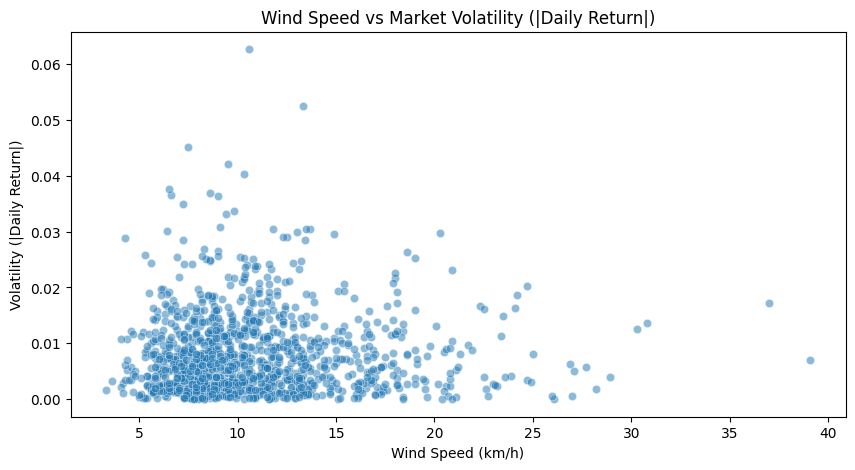

In [20]:
# Create volatility column
merged['Volatility'] = merged['Daily Return'].abs()

# Correlation between wind speed and volatility
from scipy.stats import pearsonr
corr_wind_vol, _ = pearsonr(merged['WindSpeed'], merged['Volatility'])
print(f"Correlation between Wind Speed and Volatility: {corr_wind_vol:.4f}")

# Scatterplot
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged, x='WindSpeed', y='Volatility', alpha=0.5)
plt.title('Wind Speed vs Market Volatility (|Daily Return|)')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Volatility (|Daily Return|)')
plt.show()


## 🌡️ Temperature Bins vs Return Distribution

**Goal:**  
Explore how the S&P 500's daily returns are distributed across different temperature ranges. We'll divide average daily temperatures into bins and visualize the return distribution for each.

**Why it matters:**  
This allows us to capture potential non-linear effects — for example, whether extremely hot or cold days influence the market differently than moderate days.

**Approach:**
- Bin average temperatures into 5 ranges
- Plot boxplots of returns by temperature bin


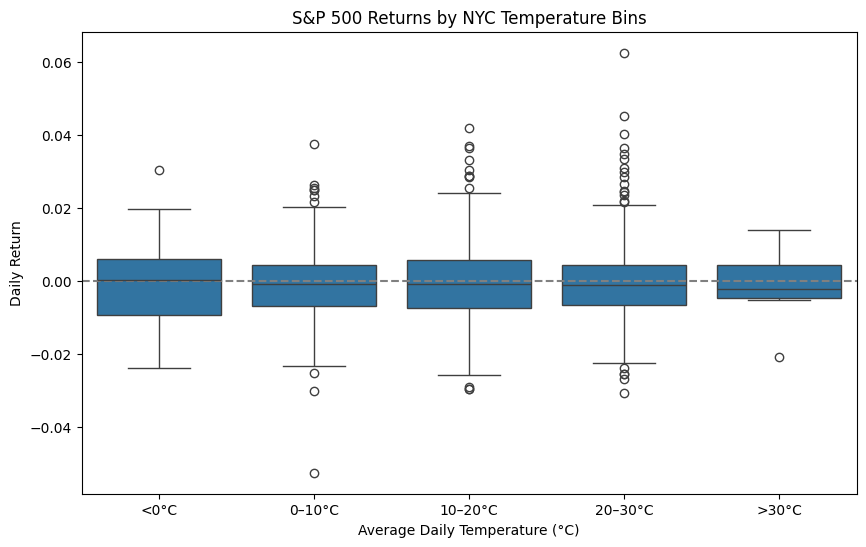

In [21]:
# Create temperature bins
merged['Temp Bin'] = pd.cut(
    merged['AvgTemp'],
    bins=[-10, 0, 10, 20, 30, 50],
    labels=['<0°C', '0–10°C', '10–20°C', '20–30°C', '>30°C']
)

# Boxplot of returns by temperature bin
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='Temp Bin', y='Daily Return')
plt.title('S&P 500 Returns by NYC Temperature Bins')
plt.xlabel('Average Daily Temperature (°C)')
plt.ylabel('Daily Return')
plt.axhline(0, color='gray', linestyle='--')
plt.show()


## 🤖 Modeling: Predicting S&P 500 Returns from Weather

**Goal:**  
Test whether we can predict daily S&P 500 returns using NYC weather features: temperature, precipitation, and wind speed.

**Why it matters:**  
If any weather variables have predictive power, we should see improved performance over a naive model. We will compare different supervised learning models.

**Models Used:**
- Linear Regression
- Polynomial Regression (degree 2)
- Decision Tree Regressor

**Metrics Evaluated:**
- Mean Squared Error (MSE)
- R² Score


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target
X = merged[['AvgTemp', 'Precip', 'WindSpeed']]
y = merged['Daily Return']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))


Linear Regression MSE: 0.00011087858726627628
Linear Regression R²: -0.002200176912676266


## 📈 Polynomial Regression (Degree 2)

**Goal:**  
Capture non-linear relationships between weather features and S&P 500 returns by expanding the feature space with interaction and squared terms.

**Why it matters:**  
Markets might respond to *extreme* weather more than moderate conditions. Polynomial regression can model such non-linear effects.

**Model Used:**  
- Polynomial Regression (Degree 2)

**Metrics Evaluated:**
- Mean Squared Error (MSE)
- R² Score


In [23]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split and fit
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)

# Evaluate
print("Polynomial Regression MSE:", mean_squared_error(y_test, y_pred_poly))
print("Polynomial Regression R²:", r2_score(y_test, y_pred_poly))


Polynomial Regression MSE: 0.0001112682088783536
Polynomial Regression R²: -0.00572185641978562


## 🌲 Decision Tree Regression

**Goal:**  
Use a decision tree to model potential threshold-based effects between weather and S&P 500 returns.

**Why it matters:**  
If certain combinations of weather (like high temp + no rain) consistently influence the market, a tree might discover those patterns without manual feature engineering.

**Model Used:**
- DecisionTreeRegressor from scikit-learn

**Metrics Evaluated:**
- Mean Squared Error (MSE)
- R² Score


In [24]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and fit decision tree
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# Evaluate
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_tree))
print("Decision Tree R²:", r2_score(y_test, y_pred_tree))


Decision Tree MSE: 0.00013136132249374314
Decision Tree R²: -0.187337824990073


## ✅ Conclusion

In this project, we explored whether weather conditions in New York City — including temperature, precipitation, and wind speed — have any measurable impact on daily returns of the S&P 500 index. Using five years of data (2019–2024), we combined historical weather and stock market data to conduct a series of correlation studies, visual analyses, and predictive modeling experiments.

Our exploratory data analysis revealed only weak relationships:
- Rainy days showed slightly **lower volatility** than dry days.
- Temperature had **no clear trend** with returns.
- Wind speed had **negligible correlation** with market behavior.

We trained several supervised learning models:
- **Linear Regression:** R² = -0.0022
- **Polynomial Regression:** R² = -0.0057
- **Decision Tree Regression:** R² = -0.1873

All models performed **worse than a baseline predictor**, indicating that weather features alone cannot explain or predict short-term stock market movements.

**Key Takeaway:**  
While it's tempting to associate market performance with external variables like weather, our analysis shows no statistical evidence that NYC weather can be used to predict S&P 500 returns. Nonetheless, this negative result is valuable — it reminds us that not all intuitive signals hold predictive power.

Future work could explore:
- Sector-specific impacts (e.g., energy or retail)
- Mood-based indicators (social media, sentiment analysis)
- Lagged effects over longer horizons (weekly/monthly)
